Buy some assets and short some other assets . There should be 3 or more assets in the portfolio.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import yfinance as yf
from pandas_datareader import data

from finquant.portfolio import build_portfolio
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
print("Market Capitalization per Company")
tickers = ["PFE", "AMZN", "ENPH", "MA"]
data.get_quote_yahoo(tickers)['marketCap']

Market Capitalization per Company


PFE      218664075264
AMZN    1126533562368
ENPH      22499883008
MA       354184232960
Name: marketCap, dtype: int64

In [3]:
print("Total Market Capitalization of the Portfolio")
data.get_quote_yahoo(tickers)['marketCap'].sum()

Total Market Capitalization of the Portfolio


1721881753600

Let's stat with importing price data for the selected stocks. 

In [4]:
start_date = pd.to_datetime("2022-01-01")
end_date = pd.to_datetime("2023-04-01")

pfizer_df = yf.download(
    "PFE", 
    start = start_date, 
    end = end_date
)["Adj Close"].rename("Pfizer")

amazon_df = yf.download(
    "AMZN", 
    start = start_date, 
    end = end_date
)["Adj Close"].rename("Amazon")

enph_df = yf.download(
    "ENPH", 
    start = start_date, 
    end = end_date
)["Adj Close"].rename("Enphase Energy Inc")

mastercard_df = yf.download(
    "MA", 
    start = start_date, 
    end = end_date
)["Adj Close"].rename("Mastercard")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Compbine all stock prices into a single Data Frame

In [5]:
stocks_list = [pfizer_df, amazon_df, enph_df, mastercard_df]

price_df = pd.concat(
    stocks_list, 
    axis=1
)

price_df.head()

,Pfizer,Amazon,Enphase Energy Inc,Mastercard
Date,,,,
2022-01-03,54.368954,170.404495,184.449997,367.615021
2022-01-04,52.334316,167.522003,178.279999,372.015045
2022-01-05,53.390026,164.356995,157.199997,370.538452
2022-01-06,52.631840,163.253998,151.490005,367.154694
2022-01-07,53.476402,162.554001,145.130005,366.807343


In [6]:
investment_df = price_df.loc["2023"]
price_df = price_df.loc["2022"]

In [7]:
print(f"Analysis days {len(price_df)}")
print(f"Investment days {len(investment_df)}")

Analysis days 251
Investment days 62


Visualizing individual stock prices. 

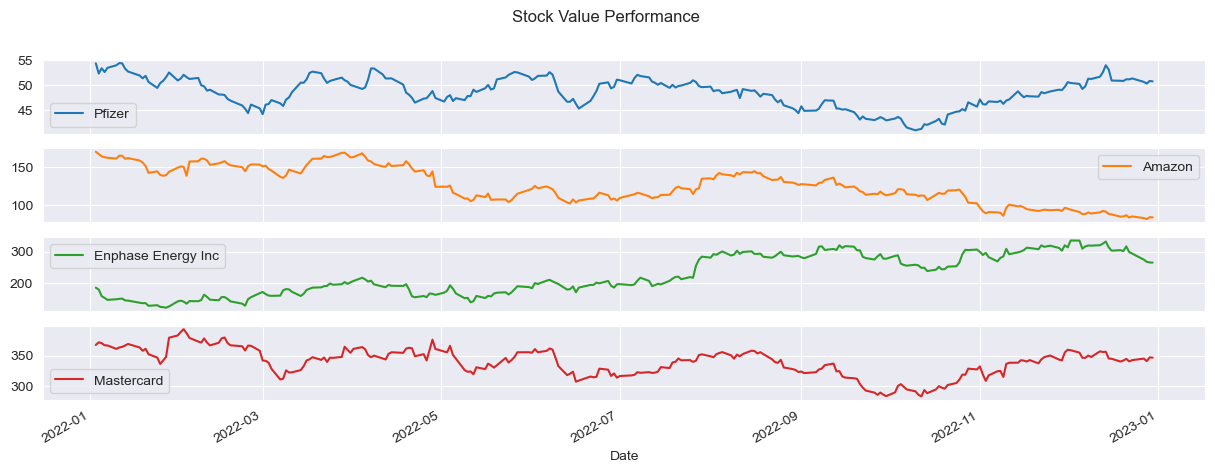

In [8]:
price_df.plot(
    figsize=(15, 5), 
    title="Stock Value Performance", 
    subplots=True, 
);

Visualizing all stock prices. 

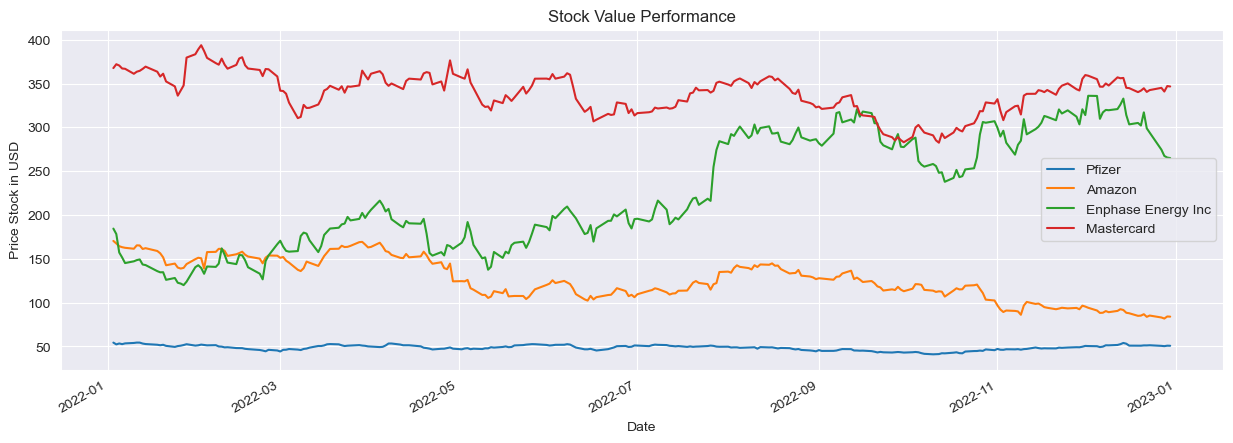

In [9]:
price_df.plot(figsize=(15, 5), title="Stock Value Performance")
plt.ylabel("Price Stock in USD");

The price of Amazon Stock is way superior compared to other assets. It's actually hard to compare the other assets because of the price difference. In order to visualize things better lets plot the returns. 

In [10]:
returns_df = price_df.pct_change().fillna(0.0)
returns_df.head()

,Pfizer,Amazon,Enphase Energy Inc,Mastercard
Date,,,,
2022-01-03,0.000000,0.000000,0.000000,0.000000
2022-01-04,-0.037423,-0.016916,-0.033451,0.011969
2022-01-05,0.020172,-0.018893,-0.118241,-0.003969
2022-01-06,-0.014201,-0.006711,-0.036323,-0.009132
2022-01-07,0.016047,-0.004288,-0.041983,-0.000946


In [11]:
returns_df.tail(3)

,Pfizer,Amazon,Enphase Energy Inc,Mastercard
Date,,,,
2022-12-28,-0.006454,-0.014692,-0.026080,-0.012162
2022-12-29,0.010433,0.028844,-0.007069,0.018307
2022-12-30,-0.001753,-0.002138,-0.001996,-0.001379


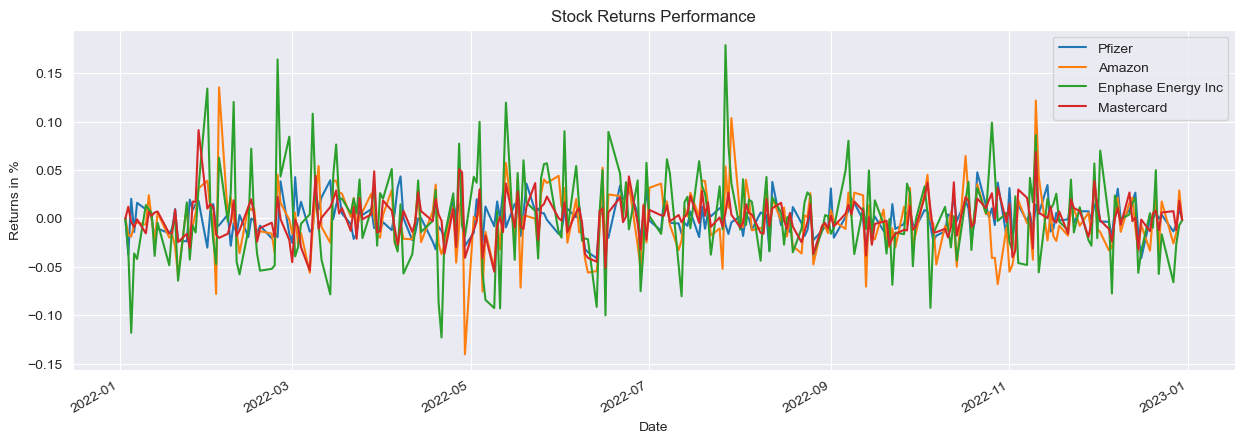

In [12]:
returns_df.plot(
    figsize=(15, 5), 
    title="Stock Returns Performance"
)
plt.ylabel("Returns in %");

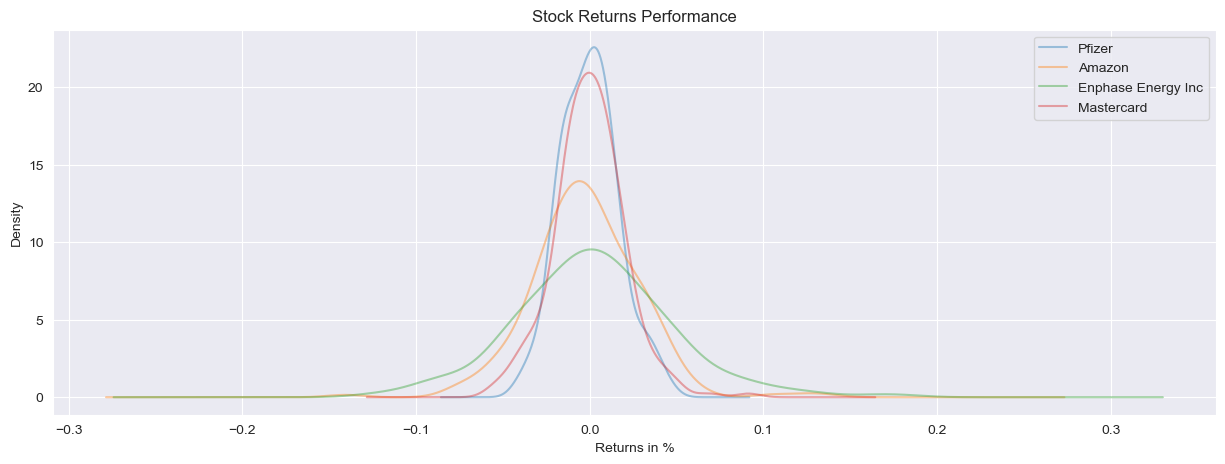

In [13]:
returns_df.plot(
    kind="kde",
    figsize=(15, 5), 
    title="Stock Returns Performance", 
    alpha=0.4
)
plt.xlabel("Returns in %");

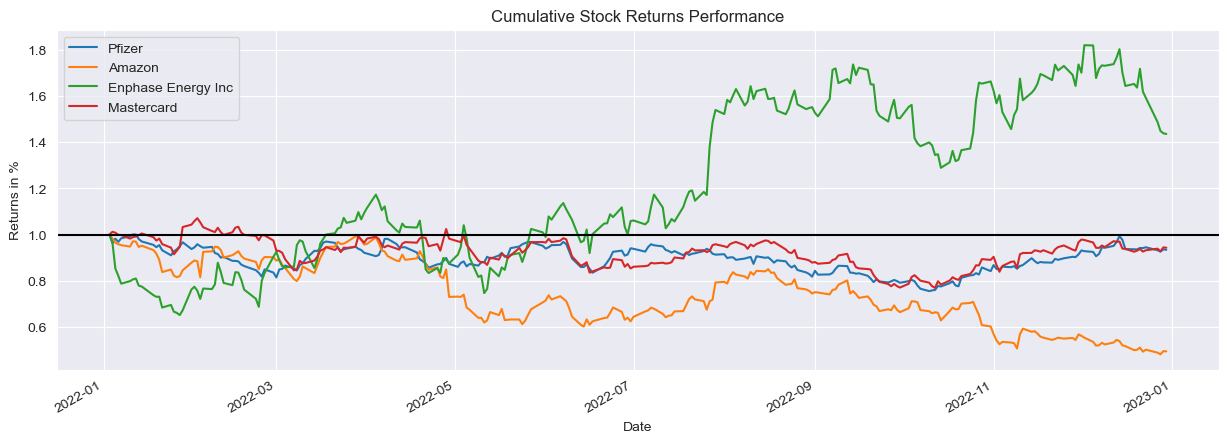

In [14]:
cum_returns_df = returns_df.add(1).cumprod()
cum_returns_df.plot(
    figsize=(15, 5), 
    title="Cumulative Stock Returns Performance", 
)
plt.axhline(y=1, color='black', linestyle='-')
plt.ylabel("Returns in %")
plt.xlabel("Date");

**Step 1** - For each investment, produce the given statistics: 
1. Average return 
2. Volatility 
3. Skewness 
4. Kurtosis 


In [15]:
print("Returns")
total_returns = (price_df.iloc[-1, :] / price_df.iloc[1, :]) - 1
total_returns

Returns


Pfizer               -0.029817
Amazon               -0.498573
Enphase Energy Inc    0.486201
Mastercard           -0.068256
dtype: float64

In [16]:
print("Average Return")
returns_df.mean()

Average Return


Pfizer               -0.000132
Amazon               -0.002320
Enphase Energy Inc    0.002477
Mastercard           -0.000029
dtype: float64

In [35]:
print("Volatility Stocks")
total_volatility = returns_df.std() * np.sqrt(252)
total_volatility

Volatility Stocks


Pfizer                0.266526
Amazon                0.500179
Enphase Energy Inc    0.727031
Mastercard            0.322553
dtype: float64

In [18]:
print("Skewdness")
price_df.skew()

Skewdness


Pfizer               -0.439765
Amazon                0.048184
Enphase Energy Inc    0.127421
Mastercard           -0.414597
dtype: float64

In [19]:
print("Kurtosis")
price_df.kurtosis().add(3)

Kurtosis


Pfizer                2.543758
Amazon                1.926383
Enphase Energy Inc    1.521203
Mastercard            2.809356
dtype: float64

**Also, compute the correlation and covariance matrix of historical returns.**


In [36]:
correlation_portfolio = returns_df.corr(method="spearman")
covariance_portfolio = returns_df.cov()

In [38]:
correlation_portfolio

,Pfizer,Amazon,Enphase Energy Inc,Mastercard
Pfizer,1.000000,0.292135,0.188038,0.411572
Amazon,0.292135,1.000000,0.540881,0.646399
Enphase Energy Inc,0.188038,0.540881,1.000000,0.440309
Mastercard,0.411572,0.646399,0.440309,1.000000


In [22]:
for column in returns_df.columns:
    print(f"{column}: {correlation_portfolio[column].nlargest(2)[1]:.3f}")

Pfizer: 0.403
Amazon: 0.596
Enphase Energy Inc: 0.500
Mastercard: 0.596


In [23]:
correlation_portfolio.min()

Pfizer                0.120740
Amazon                0.257447
Enphase Energy Inc    0.120740
Mastercard            0.403161
dtype: float64

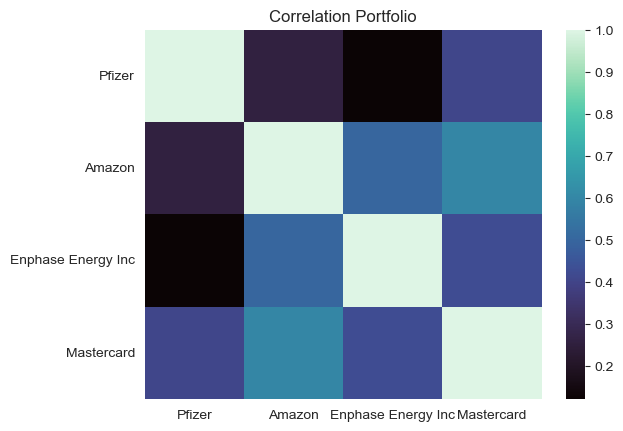

In [24]:
sns.heatmap(correlation_portfolio, cmap="mako")
plt.title("Correlation Portfolio");

In [25]:
covariance_portfolio

,Pfizer,Amazon,Enphase Energy Inc,Mastercard
Pfizer,0.000282,0.000136,0.000093,0.000138
Amazon,0.000136,0.000993,0.000722,0.000381
Enphase Energy Inc,0.000093,0.000722,0.002098,0.000394
Mastercard,0.000138,0.000381,0.000394,0.000413


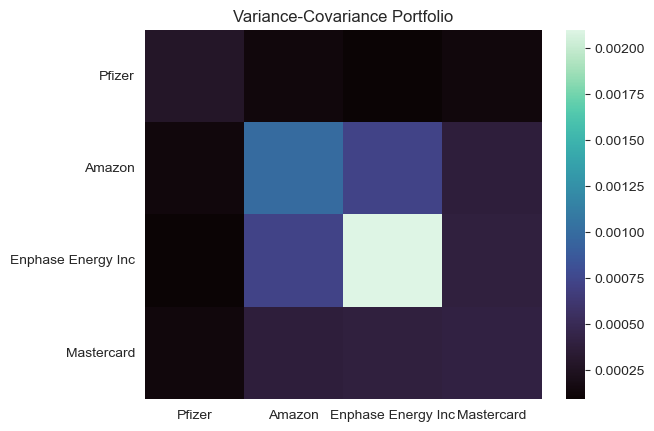

In [26]:
sns.heatmap(covariance_portfolio, cmap="mako")
plt.title("Variance-Covariance Portfolio");

Step 2 - Answer the following questions: 

1. Shorting 

    a. Can this portfolio be sold short?
    
    **Answer:** Since some expected returns are negative and some others are positive, that gives us a hint that we can have a combined strategy that includes short positions. 
    
    b. If it can be sold short, walk through the mechanics. 
    
    **Answer:** It is possible that we can maximize the return of the portfolio by having a long position on positive returns and short position in negative returns. Besides, this strategy can be beneficial in case there is systematic risk and all stocks go down for some external reason (like a pandemic). 

2. Credit Risk 

    a. Does this portfolio have credit risk? 
    **Answer:** The portfolio was built using big companies from Standard & Poor 500, the risk of credit ristk isn't zero but they are big companies with a risk close to nothing.

3. Portfolio Statistics 

    a. Compute the weighted return of the portfolio. 
    
    b. Compute the variance of the portfolio. 


In [27]:
# Calculate expected returns and sample covariance
portfolio_returns = expected_returns.mean_historical_return(price_df)
portfolio_sample_covariance = risk_models.sample_cov(price_df)

ef = EfficientFrontier(
    portfolio_returns, 
    portfolio_sample_covariance, 
    weight_bounds=(-1,1), 
    
)

weights = ef.max_sharpe()
ef.portfolio_performance(verbose=True)

Expected annual return: 74.3%
Annual volatility: 55.2%
Sharpe Ratio: 1.31


(0.7429749814658735, 0.5520576052236199, 1.309600618893785)

There is a strategy called the efficient frontier that provides the right combination of weights in the portfolio that will maximize sharp ratio. The bounds were set from -1 to 1, this makes possible go short in some stocks in case this maximizes teh overall performance.

Next, here are the optimal weights for each stock for the maximum sharpe ratio: 

In [28]:
print("Optimal Portfolio Weights")
weights

Optimal Portfolio Weights


OrderedDict([('Pfizer', 0.7350414092428205),
             ('Amazon', -1.0),
             ('Enphase Energy Inc', 0.7123856940257908),
             ('Mastercard', 0.5525728967313889)])

In [41]:
weights

OrderedDict([('Pfizer', 0.7350414092428205),
             ('Amazon', -1.0),
             ('Enphase Energy Inc', 0.7123856940257908),
             ('Mastercard', 0.5525728967313889)])

In [43]:
counter = 0
for key, value in weights.items():
    counter = counter +value
    print(counter)

0.7350414092428205
-0.26495859075717954
0.44742710326861124
1.0



4. Diversification

    a. Describe the diversification in words between the two assets.
    **Answer:** All companies present a good correlation score with Amazon, this score doesn't go up from 0.5, so it's not so bad. Pfizer comes from healthcare industry in is sligltly correlated with Amazon with a score of 0.29, the other stocks present a lower correlation. Mastercard, depite being a finance company has a good correlation score with Amazon as well 0.41. Enphase Energy Inc comes from the energy industry and presents a correlation of 0.38. All those nombers are closer to zero than to 1, which is great for the overall portfolio. 

    b. Do you think this portfolio is well diversified or not? 
    **Answer:** I think it has very good diversification, the stocks were selected from different sectors and correlation doesn't go up to 0.5 in any case. The best scenarios are were negative correlation between assets but unfortunately this didn't happend in this portfolio.

5. Comparing Portfolios 

    a. How does your portfolio compare to the others in terms of risk? 
    
    b. How does your portfolio compare to the others in terms of return? 


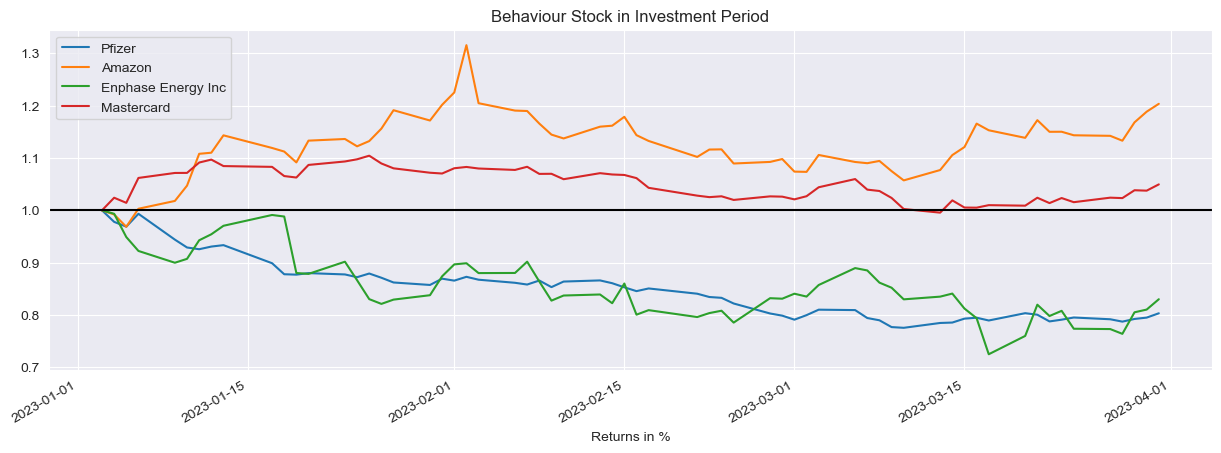

In [29]:
inv_returns_df = investment_df.pct_change().fillna(0)
inv_returns_df.add(1).cumprod()

inv_returns_df.add(1).cumprod().plot(
    figsize=(15, 5), 
    title="Behaviour Stock in Investment Period", 
)
plt.axhline(y=1, color='black', linestyle='-')
plt.xlabel("Returns in %");

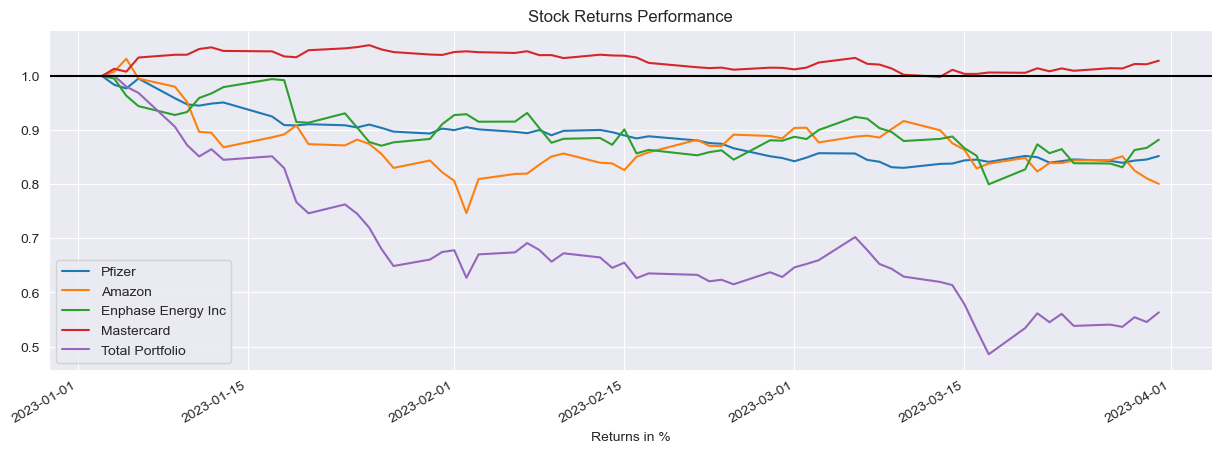

In [30]:
weighted_portfolio = inv_returns_df.multiply(weights).add(1).cumprod()
weighted_portfolio["Total Portfolio"]  = weighted_portfolio.subtract(1).sum(axis=1).add(1)

weighted_portfolio.plot(
    figsize=(15, 5), 
    title="Stock Returns Performance", 
)
plt.axhline(y=1, color='black', linestyle='-')
plt.xlabel("Returns in %");

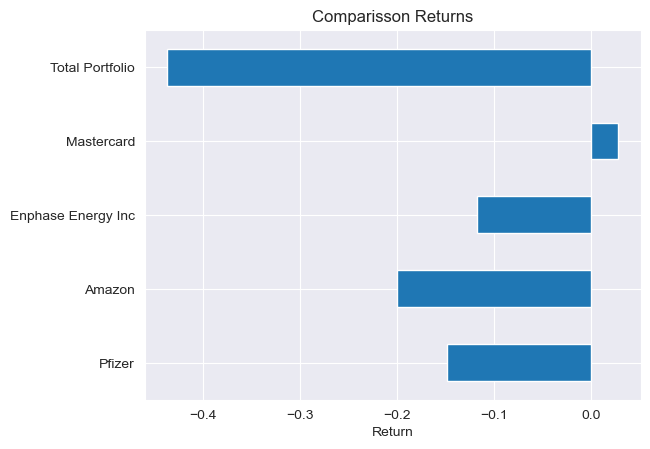

In [31]:
final_portfolio_return = weighted_portfolio.iloc[-1].subtract(1)

final_portfolio_return.plot.barh()
plt.title("Comparisson Returns")
plt.xlabel("Security")
plt.xlabel("Return");

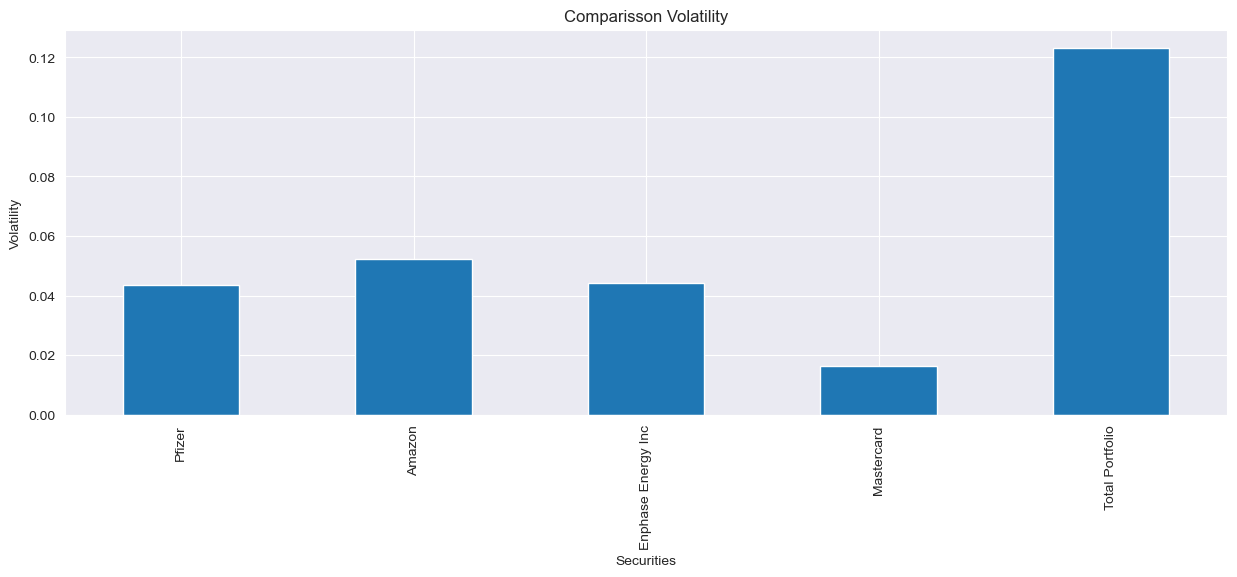

In [32]:
#returns_df.multiply(weights).add(1).cumprod().plot()
weighted_portfolio.std().plot.bar(
    figsize=(15, 5), 
    title="Comparisson Volatility"
)
plt.xlabel("Securities")
plt.ylabel("Volatility");

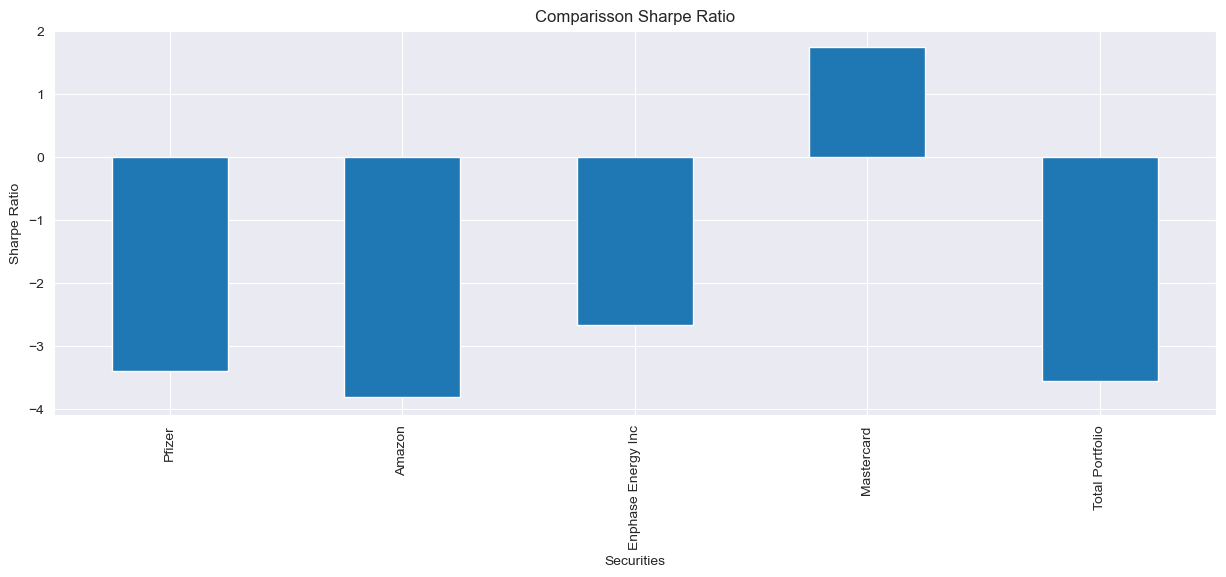

In [33]:
sharpe_ratio_portfolio = final_portfolio_return.divide(weighted_portfolio.std())

sharpe_ratio_portfolio.plot.bar(
    figsize=(15, 5), 
    title="Comparisson Sharpe Ratio"
)
plt.xlabel("Securities")
plt.ylabel("Sharpe Ratio");

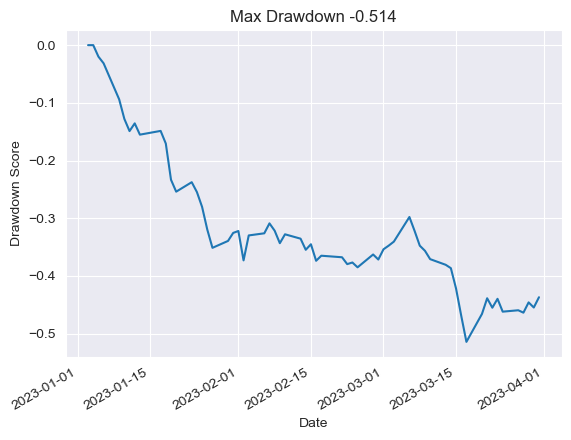

In [39]:
previous_peaks = weighted_portfolio['Total Portfolio'].cummax()
drawdown = (weighted_portfolio['Total Portfolio'] - previous_peaks) / previous_peaks
drawdown.plot()
plt.title(f"Max Drawdown {drawdown.min():.3f}")
plt.xlabel("Date")
plt.ylabel("Drawdown Score");

In [40]:
from scipy.stats import norm

def calculate_skewness(returns_data):
    """
    Alternative to scipy.stats.skew()
    Compute the skewness of the supplied Series or DataFrame
    Returns a float or a series
    """
    demeaned_returns = returns_data - returns_data.mean()
    # use the population standard deviation, so set dof=0
    sigma_returns = returns_data.std(ddof=0)
    exponent = (demeaned_returns ** 3).mean()
    return exponent / sigma_returns ** 3


def calculate_kurtosis(returns_data):
    """
    Alternative to scipy.stats.kurtosis()
    Compute the kurtosis of the supplied Series or DataFrame
    Returns a float or a series
    """
    demeaned_returns = returns_data - returns_data.mean()
    # use the population standard deviation, so set dof=0
    sigma_returns = returns_data.std(ddof=0)
    exponent = (demeaned_returns ** 4).mean()
    return exponent / sigma_returns ** 4


def calculate_var_gaussian(returns_data, level = 5, modified=True):
    """
    Returns the Parametric Gaussian VaR of a pandas Series
    or a DataFrame. 
    If "modified" is True, then the modified VaR is returned
    using the Cornish-Fisher modification. 
    """
    z_score = norm.ppf(level / 100)
    
    if modified:
        # modify the z score based on observed skewness and kurtosis
        s = calculate_skewness(returns_data)
        k = calculate_kurtosis(returns_data)
        z_score = (
            z_score + 
            (z_score ** 2 - 1) * s / 6 +
            (z_score ** 3 - 3 * z_score) * (k - 3) / 24 -
            (2 * z_score ** 3 - 5 * z_score) * (s ** 2) / 36
        )
    return -(returns_data.mean() + z_score * returns_data.std(ddof=0))

calculate_var_gaussian(weighted_portfolio)

Pfizer               -0.825695
Amazon               -0.803368
Enphase Energy Inc   -0.832391
Mastercard           -1.000406
Total Portfolio      -0.521502
dtype: float64


6. Assessing Risk 

    a. Describe economic conditions or scenarios that would affect your security. For example, the COVID-19 pandemic could disrupt travel and halt the production of new aircraft, hurting the demand for airline parts. (Note: this particular example CANNOT be used!) 
    
    **Answer:** The portfolio es expose to some idiosyncratic risk, maybe a failure in a product in any of the company, a law suite or some cyber security brach that the organizations are responsible for. 
    
    b. Determine if similar events would hurt one or both members of a portfolio. 
    **Answer:** Systematic risk like a pandemic could definetely hurt most of the assets, except Pfizer that is related to the health industry. 
    
7. Performance 
    
    a. Now describe economic conditions or scenarios that would greatly improve each security. For example, increased business and vacation travel could increase the demand for airline parts (Note: this particular example CANNOT be used!) 
    
    - Pfizer: Creation of a new vaccine for a letal disease. 
    - Amazon: Opening a new line of products.
    - Enphase Energy Inc: Inrease in the worlwide price of petroleum.
    - Mastercard: the banckruptcy of a major competitor or mastercard, like Visa. 
    
    b. Determine if similar events would help one or both members of a portfolio. 
    
    **Answer:** Not really, those events can't affect other stocks at the same time. 

8. Disrupters 

    a. List the potential influence the central bank may have on the portfolio. 
    
    **Answer:** Increase in the interest rates could create inflation and affect how financial institutions such as Mastercard are managing risk.
    
    b. List the potential influence that investment banks may have on the portfolio. 
    
    **Answer:** Investment banks could 


9. Re-assessing Risk 

    a. Do the two investments in the portfolio have the same skew? 

    **Answer:** Skewdness scores are different for all assets. 

    
    b. Is there a difference between the types of correlation? 
    
    **Answer:** Amazon is mostly related to all the other companies, but not with a correlation score larger than 0.5.

